### Creating Inference Pipeline in SageMaker to conduct feature processing and train NTM algorithm
Through this notebook, we will demonstrate how SageMaker platform can be used to automate feature processing through Glue, model training, deployment, and inference. Being able to automate these key stages in machine learning life cycle, will enable data scientists and machine learning engineers to relatively quickly create production-ready solutions for business problems.

#### We will follow the below process to illustrate key ideas
-  Create processed dataset using Amazon Glue ETL service to run SparkML jobs
-  Identify topics in the processed dataset via training NTM algorithm
-  Create inference pipeline consisting of SparkML and NTM models for real time predictions
-  Create inference pipeline consisting of SparkML and NTM models for batch predictions


#### About the Dataset
To illustrate the concepts, we will use [ABC Millions](https://www.kaggle.com/therohk/million-headlines) Headlines dataset. The dataset contains approximately a million news headlines 

### Create Features by using AWS Glue to run SparkML jobs

AWS Glue is a serverless ETL service, which can execute PySpark/Spark jobs. We will run SparkML jobs using AWS Glue. We will need to assign the current notebook a role, so it can access the Glue service.

#### Configure the current notebook to access AWS Glue service

We will first retrieve the current execution role of the notebook. We will then navigate to [IAM Dashboard](http://console.aws.amazon.com/iam/home) to edit the Role to include AWS Glue specific permission

In [1]:
import sagemaker
from sagemaker import get_execution_role

sess = sagemaker.Session()
role = get_execution_role()
print(role)

arn:aws:iam::109099157774:role/service-role/AmazonSageMaker-ExecutionRole-20180923T113724


##### Add Glue as an trusted entity to this role

If you have created a role to call Glue service, then you can simply pass the role while invoking Glue APIs. Otherwise, you can pass the execution role of the current sagemaker session when invoking Glue APIs.  

On the IAM Dashboard, click on __Roles__ on the left-side nav and search for this Role. Click on the target Role to navigate to **Summary** page. Click on **Trust Relationships** tab to add AWS Glue as an additional trusted entity.

Click on **Edit trust relationship** to add the following entry to "Service" key:

"glue.amazonaws.com"

#### Write the feature processing script using SparkML

We are assuming that the source data is already uploaded to your S3 bucket. We will upload the feature processing script (abcheadlines_processing.py) to s3, so that Glue can run the script as a Pyspark job. 


The feature processing script conducts the following main functions:
- Filter the dataset to include only ~100k abc news headlines
- Use SparkML feature transformers to tokenize the headlines, remove stop words, get word & document frequency
- The processed data to saved to the designated S3 bucket
- The SparkML PipelineModel is serialized using MLeap

[MLeap](http://mleap-docs.combust.ml/) is a serialization format and execution engine for machine learning pipelines. It serializes the pipeline to an MLeap bundle, which enables data scientists to take models to wherever they go. It supports Spark, scikit-learn and tensorflow for training pipelines.

In [2]:
default_bucket = 'ai-in-aws'
script_location = sess.upload_data(path='abcheadlines_processing.py', bucket=default_bucket, key_prefix='sagemaker/inference-pipeline/codes')

#### Upload MLeap Dependencies to S3
MLeap related software packages need to be made available to Glue job

In [4]:
!wget https://s3-us-west-2.amazonaws.com/sparkml-mleap/0.9.6/python/python.zip
!wget https://s3-us-west-2.amazonaws.com/sparkml-mleap/0.9.6/jar/mleap_spark_assembly.jar

--2019-02-22 19:47:24--  https://s3-us-west-2.amazonaws.com/sparkml-mleap/0.9.6/python/python.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.200.96
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.200.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36872 (36K) [application/zip]
Saving to: ‘python.zip.3’

python.zip.3        100%[===================>]  36.01K  --.-KB/s    in 0.08s   

2019-02-22 19:47:24 (466 KB/s) - ‘python.zip.3’ saved [36872/36872]

--2019-02-22 19:47:24--  https://s3-us-west-2.amazonaws.com/sparkml-mleap/0.9.6/jar/mleap_spark_assembly.jar
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.200.96
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.200.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17319576 (17M) [application/java-archive]
Saving to: ‘mleap_spark_assembly.jar.3’

mleap_spark_assembl 1

In [6]:
python_dep_location = sess.upload_data(path='python.zip', bucket=default_bucket, key_prefix='sagemaker/inference-pipeline/dependencies/python')
jar_dep_location = sess.upload_data(path='mleap_spark_assembly.jar', bucket=default_bucket, key_prefix='sagemaker/inference-pipeline/dependencies/jar')

#### Designate output location for processed data and SparkML model

In [7]:
from time import gmtime, strftime
import time

timestamp_prefix = strftime("%Y-%m-%d-%H-%M-%S", gmtime())

# Input location of the data, We uploaded our train.csv file to input key previously
s3_input_bucket = default_bucket
s3_input_key_prefix = 'sagemaker/inference-pipeline/input'
s3_input_fn = 'abcnews-date-text.csv'


# Output location of the data. The input data will be split, transformed, and 
# uploaded to output/train and output/validation
s3_output_bucket = default_bucket
s3_output_key_prefix = 'sagemaker/inference-pipeline/output/' + timestamp_prefix 

# the MLeap serialized SparkML model will be uploaded to output/mleap
s3_model_bucket = default_bucket
s3_model_key_prefix = s3_output_key_prefix + '/mleap'


#### Invoke Glue API

In [8]:
boto_session = sess.boto_session
s3 = boto_session.resource('s3')

glue_client = boto_session.client('glue')
job_name = 'sparkml-abcnews-' + timestamp_prefix

response = glue_client.create_job(
    Name=job_name,
    Description='PySpark job to featurize the Enron Emails dataset',
    Role=role, # you can pass your existing AWS Glue role here if you have used Glue before
    ExecutionProperty={
        'MaxConcurrentRuns': 1
    },
    Command={
        'Name': 'glueetl',
        'ScriptLocation': script_location
    },
    DefaultArguments={
        '--job-language': 'python',
        '--extra-jars' : jar_dep_location,
        '--extra-py-files': python_dep_location
    },
    AllocatedCapacity=10,
    Timeout=60,
)
glue_job_name = response['Name']

print(glue_job_name)

sparkml-abcnews-2019-02-22-19-53-09


In [9]:
job_run_id = glue_client.start_job_run(JobName=job_name,
                                       Arguments = {
                                        '--S3_INPUT_BUCKET': s3_input_bucket,
                                        '--S3_INPUT_KEY_PREFIX': s3_input_key_prefix,
                                        '--S3_INPUT_FILENAME': s3_input_fn,  
                                        '--S3_OUTPUT_BUCKET': s3_output_bucket,
                                        '--S3_OUTPUT_KEY_PREFIX': s3_output_key_prefix,
                                        '--S3_MODEL_BUCKET': s3_model_bucket,
                                        '--S3_MODEL_KEY_PREFIX': s3_model_key_prefix
                                       })['JobRunId']
print(job_run_id)

jr_53f5d67be969ae0409654c35a8a6b78cc592a19de2939f8fb47e561217a40277


#### Check Glue Job Status

In [10]:
job_run_status = glue_client.get_job_run(JobName=job_name,RunId=job_run_id)['JobRun']['JobRunState']
while job_run_status not in ('FAILED', 'SUCCEEDED', 'STOPPED'):
    job_run_status = glue_client.get_job_run(JobName=job_name,RunId=job_run_id)['JobRun']['JobRunState']
    print (job_run_status)
    time.sleep(30)

RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
SUCCEEDED


### Read the Abc News Headlines dataset (processed) from S3 bucket

In [3]:
# **Acknowledgements, Copyright Information, and Availability**
# Source: https://www.kaggle.com/therohk/million-headlines
# Source: SageMaker AWS Labs
    
import pandas as pd
import numpy as np

from sklearn.preprocessing import normalize
from scipy.sparse import csr_matrix
import io
import os
from os import listdir
from os.path import isfile, join
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker.amazon.common as smac
from sagemaker.session import s3_input
from sagemaker.predictor import csv_serializer, json_deserializer
import warnings
warnings.simplefilter(action='ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
from sagemaker.predictor import json_serializer, csv_serializer, json_deserializer, RealTimePredictor
from sagemaker.content_types import CONTENT_TYPE_CSV, CONTENT_TYPE_JSON
from sagemaker.model import Model
from sagemaker.pipeline import PipelineModel
from sagemaker.sparkml.model import SparkMLModel

## Need to cut this cell

In [4]:
s3_output_bucket = 'ai-in-aws'
s3_output_key_prefix = 'sagemaker/inference-pipeline/output/' + '2019-02-22-19-53-09' 

# the MLeap serialized SparkML model will be uploaded to output/mleap
s3_model_bucket = default_bucket
s3_model_key_prefix = s3_output_key_prefix + '/mleap'

In [ ]:
# Get CSV file in the bucket
def get_csv_files(client, bucket):
    csv_files = []
    content = client.list_objects(Bucket=bucket).get('Contents')
    for obj in content:
        key = obj.get('Key')
        if '.csv' in key:
            csv_files.append(key)
    return csv_files

In [41]:
#Read the processed dataset
s3 = boto3.resource('s3')
my_bucket = s3.Bucket(default_bucket)

files = my_bucket.objects.filter(Prefix=s3_output_key_prefix)

for f in files:
    if '.csv' in f.key:
        #print(f.key)
        abcnews_df = pd.read_csv(os.path.join('s3://', s3_output_bucket, f.key))

In [42]:
abcnews_df.shape

(110365, 200)

In [18]:
#convert dataframe (dense vector) to compressed sparse row matrix
abcnews_csr = csr_matrix(abcnews_df, dtype=np.float32)
print(abcnews_csr[:16].toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [32]:
abcnews_csr.shape[0]

110365

### Create Training, Validation and Test data sets

In [19]:
n_train = int(0.8 * abcnews_csr.shape[0])

# split train and test
train_vectors = abcnews_csr[:n_train, :] 
test_vectors = abcnews_csr[n_train:, :] 

# further split test set into validation set and test set
n_test = test_vectors.shape[0]
val_vectors = test_vectors[:n_test//2, :]
test_vectors = test_vectors[n_test//2:, :]

In [20]:
print(train_vectors.shape, test_vectors.shape, val_vectors.shape)

(88292, 200) (11037, 200) (11036, 200)


### Store CSR formatted headlines on S3

CSR = Compressed Sparse Row 

The NTM algorithm, as well as other first-party SageMaker algorithms, accepts data in RecordIO Protobuf format. The SageMaker Python API provides helper functions for easily converting your data into this format.

In [36]:
role = get_execution_role()

train_prefix = os.path.join(s3_input_key_prefix,'train')
val_prefix = os.path.join(s3_input_key_prefix, 'val')

output_prefix = 'sagemaker/inference-pipeline/output'
aux_prefix = os.path.join(s3_input_key_prefix, 'aux')

s3_train_data = os.path.join('s3://', default_bucket, train_prefix)
s3_val_data = os.path.join('s3://', default_bucket, val_prefix)
s3_aux_data = os.path.join('s3://', default_bucket, aux_prefix)
output_path = os.path.join('s3://', default_bucket, output_prefix)

print('Training Location', s3_train_data)
print('Validation set Location', s3_val_data)
print('Trained model will be saved at', output_path)
print('Auxiliary will be saved at', s3_aux_data)

Training Location s3://ai-in-aws/sagemaker/inference-pipeline/input/train
Validation set Location s3://ai-in-aws/sagemaker/inference-pipeline/input/val
Trained model will be saved at s3://ai-in-aws/sagemaker/inference-pipeline/output
Auxiliary will be saved at s3://ai-in-aws/sagemaker/inference-pipeline/input/aux


Partition the training data for parallel processing. write_spmatrix_to_sparse_tensor from SageMaker API is used to convert sparse matrix into RecordIO Protobuf format.

[Protocol buffers format](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-inference.html): 
An array containing numeric values is treated as an instance containing single dense vector.
dataElement = [1.5, 16.0, 14.0, 23.0]

It will be converted to the following representation by the SDK.
converted = {
  "features": {
    "values": dataElement
  }
}

In [38]:
def split_convert_upload(sparray, bucket, prefix, fname_template='data_part{}.pbr', n_parts=5):

    chunk_size = sparray.shape[0] // n_parts
    for i in range(n_parts):
        # Calculate start and end indices
        start = i*chunk_size
        end = (i+1)*chunk_size
        if i+1 == n_parts:
            end = sparray.shape[0]

        # Convert to record protobuf
        buf = io.BytesIO()
        smac.write_spmatrix_to_sparse_tensor(array=sparray[start:end], file=buf, labels=None)
        buf.seek(0)

        # Upload to s3 location specified by bucket and prefix
        fname = os.path.join(prefix, fname_template.format(i))
        boto3.resource('s3').Bucket(bucket).Object(fname).upload_fileobj(buf)


In [41]:
#Upload training and validation vectors
split_convert_upload(train_vectors, bucket=default_bucket, prefix=train_prefix, fname_template='data_part{}.pbr', n_parts=8)
split_convert_upload(val_vectors, bucket=default_bucket, prefix=val_prefix, fname_template='val_part{}.pbr', n_parts=3)

In [44]:
#Download the vocabulary file from s3 bucket
s3 = boto3.resource('s3')

files = my_bucket.objects.filter(Prefix=s3_output_key_prefix)

for f in files:
    if '.txt' in f.key:
        s3.Bucket(default_bucket).download_file(f.key, 'vocab.txt')

        
# s3.Bucket(default_bucket).download_file(os.path.join(s3_output_key_prefix, vocabFN), 'vocab.txt')

In [49]:
#Upload vocabulary file to auxiliary path
vocabFN_location = sess.upload_data(path='vocab.txt', bucket=default_bucket, key_prefix=aux_prefix)

### Model Training

SageMaker uses Amazon Elastic Container Registry (ECR) docker container to host the NTM training image. The ECR containers are currently available for SageMaker NTM training in different regions

Boto3 is the Amazon Web Services (AWS) Software Development Kit (SDK) for Python, which allows Python developers to write software that makes use of services like Amazon S3 and Amazon EC2

SageMaker SDK - A library for training and deploying machine learning models on Amazon SageMaker - aws/sagemaker-python-sdk.

In [9]:
container = get_image_uri(boto3.Session().region_name, 'ntm')

In [51]:
sess = sagemaker.Session()
ntm = sagemaker.estimator.Estimator(container,
                                   role,
                                   train_instance_count=2,
                                   train_instance_type='ml.c4.xlarge',
                                   output_path=output_path,
                                   sagemaker_session=sess)

##### Set Hyperparameters

__feature_dim__ - it should be set to vocabulary size <br>
__num_topics__ - topics to extract <br>
__mini_batch_size__ - this is the batch_size for each worker instance. <br>
__epochs__ - the maximal number of epochs to train for. <br>
__num_patience_epochs__ and tolerance control the early shopping behavior. Improvements smaller than the tolerance are not considered as improvement <br>
__optimizer and learning_rate__ - Adadelta optimizer and learning rate is not required <br>

In [45]:
s3_train_data

's3://ai-in-aws/sagemaker/inference-pipeline/input/train'

In [52]:
num_topics = 5
vocab_size = 200
ntm.set_hyperparameters(num_topics=num_topics, feature_dim=vocab_size, mini_batch_size=30, epochs=150, num_patience_epochs=3, tolerance=.001)

In [53]:
s3_train = s3_input(s3_train_data, distribution='ShardedByS3Key')

In [54]:
s3_aux = s3_input(s3_aux_data, distribution='FullyReplicated', content_type='text/plain')

In [55]:
ntm.fit({'train': s3_train, 'test': s3_val_data, 'auxiliary': s3_aux})

INFO:sagemaker:Creating training-job with name: ntm-2019-02-17-23-21-55-061


2019-02-17 23:21:55 Starting - Starting the training job...
2019-02-17 23:21:56 Starting - Launching requested ML instances......
2019-02-17 23:23:02 Starting - Preparing the instances for training.........
2019-02-17 23:24:44 Downloading - Downloading input data
2019-02-17 23:24:44 Training - Training image download completed. Training in progress.
Docker entrypoint called with argument(s): train
[02/17/2019 23:24:43 INFO 140262573676352] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_patience_epochs': u'3', u'clip_gradient': u'Inf', u'encoder_layers': u'auto', u'optimizer': u'adadelta', u'_kvstore': u'auto_gpu', u'rescale_gradient': u'1.0', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'learning_rate': u'0.01', u'_data_format': u'record', u'sub_sample': u'1.0', u'epochs': u'50', u'weight_decay': u'0.0', u'_num_kv_servers': u'auto', u'encoder_layers_activation': u'sigmoid', u'mini_batch_size': u'256', u'toler

[02/17/2019 23:24:55 WARNING 140262573676352] 0 out of 200 in vocabulary do not have embeddings! Default vector used for unknown embedding!
[02/17/2019 23:24:55 INFO 140262573676352] Vocab embedding shape
[02/17/2019 23:24:55 INFO 140262573676352] Number of GPUs being used: 0
[02/17/2019 23:24:55 INFO 140262573676352] Create Store: dist_async
[02/17/2019 23:24:57 WARNING 140471953696576] 0 out of 200 in vocabulary do not have embeddings! Default vector used for unknown embedding!
[02/17/2019 23:24:57 INFO 140471953696576] Vocab embedding shape
[02/17/2019 23:24:57 INFO 140471953696576] Number of GPUs being used: 0
[02/17/2019 23:24:57 INFO 140471953696576] Create Store: dist_async
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max

[02/17/2019 23:26:05 INFO 140262573676352] # Finished training epoch 3 on 44144 examples from 1472 batches, each of size 30.
[02/17/2019 23:26:05 INFO 140262573676352] Metrics for Training:
[02/17/2019 23:26:05 INFO 140262573676352] Loss (name: value) total: 3.59882226068
[02/17/2019 23:26:05 INFO 140262573676352] Loss (name: value) kld: 0.253629735852
[02/17/2019 23:26:05 INFO 140262573676352] Loss (name: value) recons: 3.34519252578
[02/17/2019 23:26:05 INFO 140262573676352] Loss (name: value) logppx: 3.59882226068
[02/17/2019 23:26:05 INFO 140262573676352] #quality_metric: host=algo-1, epoch=3, train total_loss <loss>=3.59882226068
[02/17/2019 23:26:05 INFO 140262573676352] Timing: train: 22.68s, val: 0.00s, epoch: 22.69s
[02/17/2019 23:26:05 INFO 140262573676352] #progress_metric: host=algo-1, completed 2 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 1472, "sum": 1472.0, "min": 1472}, "Number of Batches Since Last Reset": {"count": 1, "max

[02/17/2019 23:26:51 INFO 140262573676352] # Finished training epoch 5 on 44144 examples from 1472 batches, each of size 30.
[02/17/2019 23:26:51 INFO 140262573676352] Metrics for Training:
[02/17/2019 23:26:51 INFO 140262573676352] Loss (name: value) total: 3.25320331351
[02/17/2019 23:26:51 INFO 140262573676352] Loss (name: value) kld: 0.446331709764
[02/17/2019 23:26:51 INFO 140262573676352] Loss (name: value) recons: 2.80687160276
[02/17/2019 23:26:51 INFO 140262573676352] Loss (name: value) logppx: 3.25320331351
[02/17/2019 23:26:51 INFO 140262573676352] #quality_metric: host=algo-1, epoch=5, train total_loss <loss>=3.25320331351
[02/17/2019 23:26:51 INFO 140262573676352] patience losses:[3.8001116658466452, 3.5988222606804059, 3.4414298137029014] min patience loss:3.4414298137 current loss:3.25320331351 absolute loss difference:0.188226500197
[02/17/2019 23:26:51 INFO 140262573676352] Timing: train: 22.65s, val: 0.00s, epoch: 22.65s
[02/17/2019 23:26:51 INFO 140262573676352] #pro

[02/17/2019 23:27:37 INFO 140262573676352] # Finished training epoch 7 on 44144 examples from 1472 batches, each of size 30.
[02/17/2019 23:27:37 INFO 140262573676352] Metrics for Training:
[02/17/2019 23:27:37 INFO 140262573676352] Loss (name: value) total: 3.02782568465
[02/17/2019 23:27:37 INFO 140262573676352] Loss (name: value) kld: 0.568294474504
[02/17/2019 23:27:37 INFO 140262573676352] Loss (name: value) recons: 2.45953120641
[02/17/2019 23:27:37 INFO 140262573676352] Loss (name: value) logppx: 3.02782568465
[02/17/2019 23:27:37 INFO 140262573676352] #quality_metric: host=algo-1, epoch=7, train total_loss <loss>=3.02782568465
[02/17/2019 23:27:37 INFO 140262573676352] patience losses:[3.4414298137029014, 3.2532033135061678, 3.1247392065283179] min patience loss:3.12473920653 current loss:3.02782568465 absolute loss difference:0.0969135218772
[02/17/2019 23:27:37 INFO 140262573676352] Timing: train: 22.87s, val: 0.00s, epoch: 22.88s
[02/17/2019 23:27:37 INFO 140262573676352] #p

[02/17/2019 23:28:22 INFO 140262573676352] # Finished training epoch 9 on 44144 examples from 1472 batches, each of size 30.
[02/17/2019 23:28:22 INFO 140262573676352] Metrics for Training:
[02/17/2019 23:28:22 INFO 140262573676352] Loss (name: value) total: 2.97319692356
[02/17/2019 23:28:22 INFO 140262573676352] Loss (name: value) kld: 0.60796623528
[02/17/2019 23:28:22 INFO 140262573676352] Loss (name: value) recons: 2.36523068759
[02/17/2019 23:28:22 INFO 140262573676352] Loss (name: value) logppx: 2.97319692356
[02/17/2019 23:28:22 INFO 140262573676352] #quality_metric: host=algo-1, epoch=9, train total_loss <loss>=2.97319692356
[02/17/2019 23:28:22 INFO 140262573676352] patience losses:[3.1247392065283179, 3.0278256846510847, 2.9886153531247293] min patience loss:2.98861535312 current loss:2.97319692356 absolute loss difference:0.0154184295647
[02/17/2019 23:28:22 INFO 140262573676352] Timing: train: 22.46s, val: 0.00s, epoch: 22.46s
[02/17/2019 23:28:22 INFO 140262573676352] #pr

[02/17/2019 23:29:08 INFO 140262573676352] # Finished training epoch 11 on 44144 examples from 1472 batches, each of size 30.
[02/17/2019 23:29:08 INFO 140262573676352] Metrics for Training:
[02/17/2019 23:29:08 INFO 140262573676352] Loss (name: value) total: 2.95378539407
[02/17/2019 23:29:08 INFO 140262573676352] Loss (name: value) kld: 0.638607970118
[02/17/2019 23:29:08 INFO 140262573676352] Loss (name: value) recons: 2.31517742553
[02/17/2019 23:29:08 INFO 140262573676352] Loss (name: value) logppx: 2.95378539407
[02/17/2019 23:29:08 INFO 140262573676352] #quality_metric: host=algo-1, epoch=11, train total_loss <loss>=2.95378539407
[02/17/2019 23:29:08 INFO 140262573676352] patience losses:[2.9886153531247293, 2.9731969235599904, 2.9637781818707785] min patience loss:2.96377818187 current loss:2.95378539407 absolute loss difference:0.00999278780343
[02/17/2019 23:29:08 INFO 140262573676352] Timing: train: 22.36s, val: 0.00s, epoch: 22.36s
[02/17/2019 23:29:08 INFO 140262573676352]

[02/17/2019 23:29:54 INFO 140262573676352] # Finished training epoch 13 on 44144 examples from 1472 batches, each of size 30.
[02/17/2019 23:29:54 INFO 140262573676352] Metrics for Training:
[02/17/2019 23:29:54 INFO 140262573676352] Loss (name: value) total: 2.95553899701
[02/17/2019 23:29:54 INFO 140262573676352] Loss (name: value) kld: 0.661925343996
[02/17/2019 23:29:54 INFO 140262573676352] Loss (name: value) recons: 2.29361365152
[02/17/2019 23:29:54 INFO 140262573676352] Loss (name: value) logppx: 2.95553899701
[02/17/2019 23:29:54 INFO 140262573676352] #quality_metric: host=algo-1, epoch=13, train total_loss <loss>=2.95553899701
[02/17/2019 23:29:54 INFO 140262573676352] patience losses:[2.9637781818707785, 2.9537853940673497, 2.9533414614373359] min patience loss:2.95334146144 current loss:2.95553899701 absolute loss difference:0.00219753557357
[02/17/2019 23:29:54 INFO 140262573676352] Bad epoch: loss has not improved (enough). Bad count:2
[02/17/2019 23:29:54 INFO 1402625736

[02/17/2019 23:30:40 INFO 140262573676352] # Finished training epoch 15 on 44144 examples from 1472 batches, each of size 30.
[02/17/2019 23:30:40 INFO 140262573676352] Metrics for Training:
[02/17/2019 23:30:40 INFO 140262573676352] Loss (name: value) total: 2.96664211111
[02/17/2019 23:30:40 INFO 140262573676352] Loss (name: value) kld: 0.670781430127
[02/17/2019 23:30:40 INFO 140262573676352] Loss (name: value) recons: 2.29586068383
[02/17/2019 23:30:40 INFO 140262573676352] Loss (name: value) logppx: 2.96664211111
[02/17/2019 23:30:40 INFO 140262573676352] #quality_metric: host=algo-1, epoch=15, train total_loss <loss>=2.96664211111
[02/17/2019 23:30:40 INFO 140262573676352] patience losses:[2.9533414614373359, 2.9555389970109083, 2.9581367403700733] min patience loss:2.95334146144 current loss:2.96664211111 absolute loss difference:0.0133006496706
[02/17/2019 23:30:40 INFO 140262573676352] Bad epoch: loss has not improved (enough). Bad count:4
[02/17/2019 23:30:40 INFO 14026257367


2019-02-17 23:30:48 Uploading - Uploading generated training model
2019-02-17 23:30:48 Completed - Training job completed
Billable seconds: 756


#### Topics extracted, with the confidence range

[0.56, 0.93] dies charged found dead man crash woman murder accident missing three car search killed attack death injured charge four baghdad

[0.61, 0.82] lead final wins cup takes test win first england world open face title take second one top day court charges

[0.49, 0.78] set back pakistan residents win appeal top rain clash home killed world crash england water title return bid plans two

[0.37, 0.88] deal probe new wa death record power denies says australian fire police open council home pay vic hits face rejects

[0.49, 0.95] un report pm war calls iraq australia plans troops inquiry urged warns iraqi us election tour defends may bush fire

In [56]:
print('Training job name: {}'.format(ntm.latest_training_job.job_name))

Training job name: ntm-2019-02-17-23-21-55-061


### Model Hosting and Inference

In [28]:
job_name = 'ntm-2019-02-17-23-21-55-061'
region = 'us-east-1'

image_name = container

# Configuration of EndPoint
endpoint_name = sess.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

ntm_predictor = sagemaker.predictor.RealTimePredictor(
    endpoint_name, 
    sagemaker_session=sess, 
    content_type="application/json")

#ntm_predictor = ntm.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating endpoint with name ntm-2019-02-17-23-21-55-061


----------------------------------------------------------------------------!

In [9]:
print('Endpoint name: {}'.format(ntm_predictor.endpoint))

Endpoint name: ntm-2019-02-17-23-21-55-061


### Inference with CSV

In [29]:
ntm_predictor.content_type = 'text/csv'
ntm_predictor.serializer = csv_serializer
ntm_predictor.deserializer = json_deserializer

In [21]:
#Convert test vectors from compressed sparse matrix to dense matrix
test_data = np.array(test_vectors.todense())

In [38]:
test_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [22]:
results = ntm_predictor.predict(test_data[:5])
print(results)

{'predictions': [{'topic_weights': [0.0783672631, 0.0791266486, 0.0964549705, 0.0687241182, 0.6773269773]}, {'topic_weights': [0.1267461479, 0.1984856278, 0.4162698984, 0.1384287626, 0.1200695932]}, {'topic_weights': [0.0883882344, 0.102564916, 0.3129917681, 0.4054643512, 0.0905907378]}, {'topic_weights': [0.5119438171, 0.23860237, 0.0679632947, 0.1207858324, 0.0607047118]}, {'topic_weights': [0.4962130785, 0.1524228603, 0.0667938441, 0.2229692191, 0.0616010763]}]}


In [23]:
predictions = np.array([prediction['topic_weights'] for prediction in results['predictions']])
print(predictions)

[[0.07836726 0.07912665 0.09645497 0.06872412 0.67732698]
 [0.12674615 0.19848563 0.4162699  0.13842876 0.12006959]
 [0.08838823 0.10256492 0.31299177 0.40546435 0.09059074]
 [0.51194382 0.23860237 0.06796329 0.12078583 0.06070471]
 [0.49621308 0.15242286 0.06679384 0.22296922 0.06160108]]


Text(0.5,0,'Topic ID')

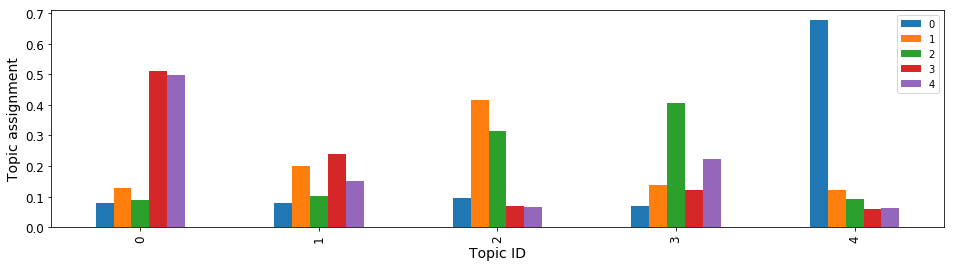

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

fs=12
df=pd.DataFrame(predictions.T)
df.plot(kind='bar', figsize=(16,4), fontsize=fs)
plt.ylabel('Topic assignment', fontsize=fs+2)
plt.xlabel('Topic ID', fontsize=fs+2)

### Using SageMaker to create inference pipeline

SageMaker Python SDK provides classes, such Model, SparkMLModel, & PipelineModel, to create an inference pipeline that can be used to conduct feature processing and then fit target algorithm to the processed data. Subsequently, the PipelineModel created can be deployed as an endpoint for real time inferences. Additionally, the PipelineModel can also be deployed in batch mode (Batch Transform), to get inferences for a large volume of data points. 

The SparkMLModel requires schema of the input dataset

In [11]:
import json
schema = {
    "input": [
        {
            "name": "headline_text",
            "type": "string"
        }
    ],
    "output": 
        {
            "name": "features",
            "type": "double",
            "struct": "vector"
        }
}
schema_json = json.dumps(schema)
print(schema_json)

{"input": [{"name": "headline_text", "type": "string"}], "output": {"name": "features", "type": "double", "struct": "vector"}}


### Cut the cell

In [13]:
#Get the data location of the trained ntm model
#modeldataurl = 's3://ai-in-aws/sagemaker/inference-pipeline/output/ntm-2019-02-17-23-21-55-061/output/model.tar.gz'
s3_ntm_output_key_prefix = 'sagemaker/inference-pipeline/output'
modeldataurl = 's3://{}/{}/{}/{}'.format(s3_model_bucket, s3_ntm_output_key_prefix, 'ntm-2019-02-17-23-21-55-061', 'output/model.tar.gz')
print(modeldataurl)

from time import gmtime, strftime
import time

s3://ai-in-aws/sagemaker/inference-pipeline/output/ntm-2019-02-17-23-21-55-061/output/model.tar.gz


#### I. Real Time Predictions

In [14]:
#Get MLeap serialized model
s3_ntm_output_key_prefix = 'sagemaker/inference-pipeline/output'

#Get the data location of the trained ntm model
#modeldataurl = 's3://{}/{}/{}/{}'.format(s3_model_bucket, s3_ntm_output_key_prefix, ntm.latest_training_job.job_name, 'output/model.tar.gz')

sparkml_data = 's3://{}/{}/{}'.format(s3_model_bucket, s3_model_key_prefix, 'model.tar.gz')

ntm_model = Model(model_data=modeldataurl, image=container)

# passing the schema defined above by using an environment variable that sagemaker-sparkml-serving understands
sparkml_model = SparkMLModel(model_data=sparkml_data, env={'SAGEMAKER_SPARKML_SCHEMA' : schema_json})

model_name = 'inference-pipeline-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
sm_model = PipelineModel(name=model_name, role=role, models=[sparkml_model, ntm_model])

##### Deploy the PipelineModel 

In [ ]:
endpoint_name = 'inference-pipeline-ep-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
sm_model.deploy(initial_instance_count=1, instance_type='ml.c4.xlarge', endpoint_name=endpoint_name)

##### Pass json payload
Because the output of SparkML model is a dense vector, we will use JSON format (instead of CSV format) to pass input to the pipeline model.

In [43]:
payload = {
    "schema": {
        "input": [
        {
            "name": "headline_text",
            "type": "string"
        }, 
    ],
    "output": 
        {
            "name": "features",
            "type": "double",
            "struct": "vector"
        }
    },
    "data": [
            #["murder conviction court of criminal appeal"]
        #["is dabiq captured opposition forces"]
        ["lisa scaffidi public hearing possible over expenses scandal"]
            ]
            
}

predictor = RealTimePredictor(endpoint=endpoint_name, sagemaker_session=sess, serializer=json_serializer,
                                content_type=CONTENT_TYPE_JSON, accept=CONTENT_TYPE_CSV)

print(predictor.predict(payload))

b'{"predictions":[{"topic_weights":[0.1988317221,0.2747220397,0.0973563567,0.0495365895,0.379553318]}]}'


#### II. Create batch transform job

In [12]:
#Number of headlines - choose 10-15
input_data_path = 's3://{}/{}/{}'.format(default_bucket, 'sagemaker/inference-pipeline/batch', 'abcnews-batch-input.csv')

output_data_path = 's3://{}/{}/{}'.format(default_bucket, 'sagemaker/inference-pipeline/batch_output/abcnews', timestamp_prefix)

job_name = 'serial-inference-batch-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

#Define the SageMaker PipelineModel Name
model_name = 'inference-pipeline-2019-02-22-01-15-00'

transformer = sagemaker.transformer.Transformer(
    # This was the model created using PipelineModel and it contains feature processing and NTM stages
    model_name = model_name,
    instance_count = 1,
    instance_type = 'ml.m4.xlarge',
    strategy = 'SingleRecord',
    assemble_with = 'Line',
    output_path = output_data_path,
    base_transform_job_name='serial-inference-batch',
    sagemaker_session=sess,
    accept = CONTENT_TYPE_CSV
)

transformer.transform(data = input_data_path,
                      job_name = job_name,
                      content_type = CONTENT_TYPE_CSV, 
                      split_type = 'Line')
transformer.wait()

INFO:sagemaker:Creating transform job with name: serial-inference-batch-2019-02-22-01-21-21


................................................!
